In [1]:
import csv
import lightkurve as lk
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import numpy as np
import astropy.units as u
from astropy.modeling.models import Sine1D
from sklearn.linear_model import LinearRegression
import pandas as pd
from astropy.modeling import models, fitting
from lightkurve.correctors import PLDCorrector
import lmfit
from astropy.timeseries import LombScargle

In [2]:
# Define dataframes
df = pd.read_csv('query_data/comma_test_query.csv')
all_df = df[['iau_name', 'i', 'porb', 'porbe']]

# Dataframe with orbital period calculations
porb_df = all_df[all_df['porb'] != 0].reset_index()
# Dataframe without orbital period calculations
no_porb_df = all_df[all_df['porb'] == 0].reset_index()

index                             6
iau_name    SDSSJ002620.41+144409.5
i                           16.6517
porb                            0.0
porbe                           0.0
Name: 6, dtype: object 

SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 70 2023   SPOC     120   336693494      0.0 



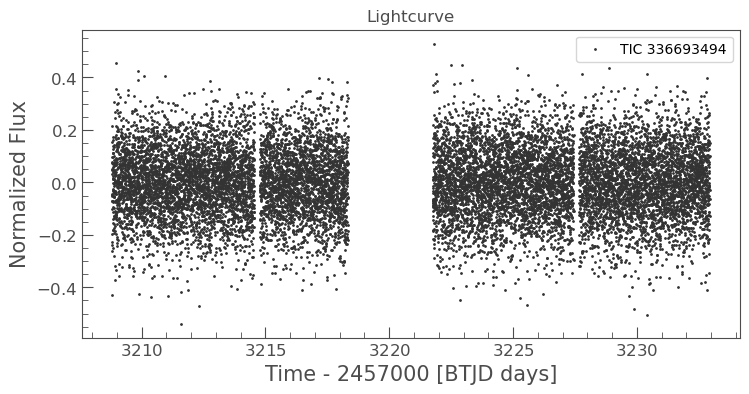

/Users/bella/anaconda3/envs/pceb_ob_ENV/lib/python3.12/site-packages/astropy/units/quantity.py:666: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


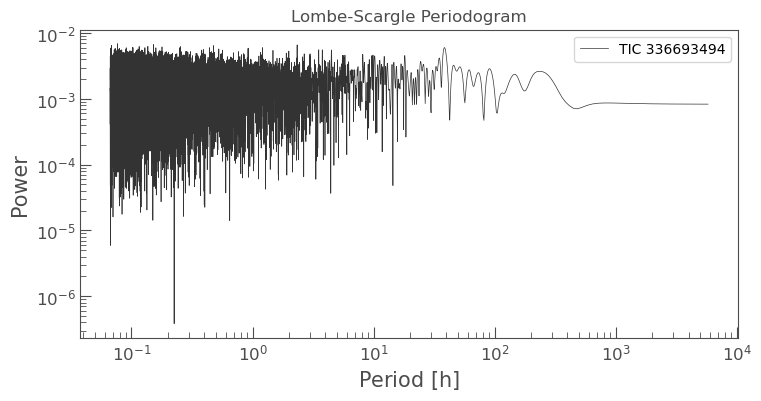

In [5]:
# Pull lightcurve data for that star
star_info = no_porb_df.iloc[6]
star_result = lk.search_lightcurve(star_info['iau_name'], mission = 'TESS')
print(star_info, '\n')
print(star_result, '\n')

# Get lightcurve data -> MAKE ME SO SELECTS ROW WITH LOWEST CADENCE
star_lightcurve = star_result[0].download().remove_nans().remove_outliers().normalize() - 1
time = star_lightcurve.time.value
flux = star_lightcurve.flux - star_lightcurve.flux_err
flux_lower_err = star_lightcurve.flux - star_lightcurve.flux_err
flux_upper_err = star_lightcurve.flux + star_lightcurve.flux_err

# Plot lightcurve
star_lightcurve.scatter()
plt.title('Lightcurve')
plt.legend()
plt.show()

# Periodogram bounds
min_period = (2*star_result[0].exptime.value) / (60*60) * u.hr
max_period = 14*24 * u.hr

# Plot periodogram
star_periodogram = star_lightcurve.to_periodogram(oversample_factor = 10, minimum_period = min_period)
star_periodogram.plot(view = 'period', scale = 'log', unit = u.hr)
plt.title('Lombe-Scargle Periodogram')
plt.legend()
plt.show()

In [6]:
# Calculate the period at max power and standard deviation of the periodogram
period_at_max_power = star_periodogram.period_at_max_power.value 
max_power = star_periodogram.max_power.value 
std_dev = np.std(star_periodogram.power)

# Calculate the "real orbital period range"
five_sigma_range = 5 * std_dev

# Check if the maximum power is above the 5-sigma range
if max_power > five_sigma_range:
    print(f"The period at max power {period_at_max_power} days is likely real (above 5-sigma range)")
else:
        print(f"The period at max power {period_at_max_power} days is likely NOT real (below 5-sigma range)")

The period at max power 0.0031985107281557288 days is likely NOT real (below 5-sigma range)


Script goals:
- don't define variables as max_period, just use the actual value in the iterator (only define if used many times)
- show each plot and determine if the periodogram is any good
